In [1]:
import torch
import models

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = 128*128
OUTPUT_DIM = 64*64
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = models.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = models.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = models.Seq2Seq(enc, dec, DEVICE).to(DEVICE)


In [4]:
model.load_state_dict(torch.load('weights/simple_rnn_rand_15.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import torch
import loss
import tqdm
import pyproj


In [7]:
p = pathlib.Path(f'data/data_random_15.npz')
res = np.load(p)

times = res['times']
data = res['data']

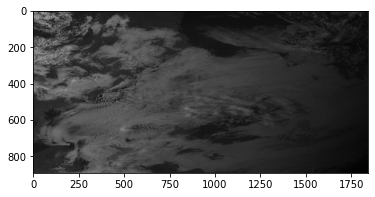

In [8]:
plt.imshow(data[0], cmap='gray')

In [10]:
def get_crop_idxs():
    rand_x = np.random.randint(550, 950 - 128)
    rand_y = np.random.randint(375, 700 - 128)
    
    yslice = slice(rand_y, rand_y + 128)
    xslice = slice(rand_x, rand_x + 128)
    
    return xslice, yslice

In [12]:
def predict(model, srcs):
    batch_size = srcs.shape[0]
        
    #tensor to store decoder outputs
    outputs = torch.zeros(batch_size, 24, 64, 64).to(DEVICE)
    
    #last hidden state of the encoder is used as the initial hidden state of the decoder
    hidden, cell = model.encoder(srcs)
    
    #first input to the decoder is the last image in the hour
    # shape: (batch_size, 1, 64, 64)
    input = srcs[:,-1,32:96,32:96]
    input = torch.unsqueeze(input, 1)
    
    for t in range(24):
        output, hidden, cell = model.decoder(input, hidden, cell)
        # images of shape (batch_size, 64, 64)
        output = output.view(batch_size, 64, 64)
        outputs[:,t,:,:] = output
        
        input = output
        input = torch.unsqueeze(input, 1)
    
    return outputs

In [15]:
xs.shape

(30, 12, 128, 128)

In [22]:
criterion = loss.MS_SSIMLoss(channels=24)

In [25]:
np.random.seed(7)

model.eval()
scores = []
running_total = 0

mean = 209.
std = 60.

pbar = tqdm.notebook.tqdm(range(0, len(times) - 36, 10))
for idx in pbar:
    diff = (times[idx+36].astype('M8[m]') - times[idx].astype('M8[m]')).astype(int)
    if diff != 36 * 5:
        continue
    
    crops = 30
    _scores = []
    xs = np.zeros((crops, 12, 128, 128))
    ys = np.zeros((crops, 24, 64, 64))
    for i in range(crops):
        xslice, yslice = get_crop_idxs()
        imgs = (data[idx:idx+36, yslice, xslice] - mean) / std
        xs[i] = imgs[:12]
        ys[i] = imgs[12:36,32:96,32:96]
        
    xs = torch.FloatTensor(xs)
    ys = torch.FloatTensor(ys)
    yhats = predict(model, xs) 
#     score = float(get_mssim(yhats * std + mean, ys * std + mean))
    score = 1.0 - criterion(yhats * std + mean, ys * std + mean).item()
    _scores.append(score)
    running_total += score
    
    scores.append(_scores)
    pbar.set_description(f'MSSIM: {running_total/(len(scores))}')
    


  0%|          | 0/178 [00:00<?, ?it/s]